In [1]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [2]:
import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation
import dipy.data as dpd
from sklearn.utils import class_weight

In [3]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
import bundlenet as bn

In [5]:
import dask.bag as db
import warnings
warnings.filterwarnings('ignore')

In [6]:
ls /home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles

AF_L.trk             CCMid.trk  CST_R.trk   IFOF_L.trk
AF_R.trk             C_L.trk    F_L.trk     MCP.trk
CC_ForcepsMajor.trk  C_R.trk    F_R.trk     UF_L.trk
CC_ForcepsMinor.trk  CST_L.trk  IF0F_R.trk  UF_R.trk


In [7]:
bundle_files = sorted(glob('/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/*.trk'))

In [8]:
diff_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape=diff_img.shape[0:3]
vol_shape

(182, 218, 182)

In [9]:
bundle_files

['/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/AF_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/AF_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CCMid.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CC_ForcepsMajor.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CC_ForcepsMinor.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CST_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CST_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/C_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/C_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/F_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/F_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/IF0F_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/IFOF_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/MCP.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/UF_L.trk',
 '/home/ubuntu/A

In [10]:
n_streamlines = []
bundle_names = []
for fname in bundle_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    n_streamlines.append(len(streamlines))


In [11]:
np.min(n_streamlines), len(n_streamlines)

(72, 16)

In [12]:
take_n_bundles = len(n_streamlines)
take_n_sl = np.min(n_streamlines)

test_perc=0
val_perc=0.2
size_slimage = 100
dil_iters = 5

In [13]:
%%time
import imp  
imp.reload(bn)
streamlines_loaded = db.from_sequence(bundle_files).map(bn.read_sl_mni).compute()
streamlines_processed = db.from_sequence(streamlines_loaded).map(bn.process_sl,take_n_sl,vol_shape,size_slimage,dil_iters).compute() 
data_train, data_test, data_val, labels_train, labels_test, labels_val = bn.partition_testtrain(test_perc, val_perc, streamlines_processed)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
CPU times: user 4.34 s, sys: 576 ms, total: 4.92 s
Wall time: 19.1 s


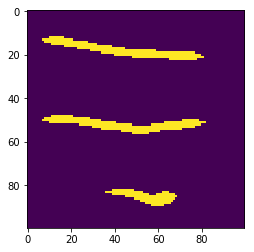

In [14]:
plt.imshow(streamlines_processed[5][1,:,:,0])

In [15]:
img_rows = size_slimage
img_cols = size_slimage
batch_size = 4
epochs = 16
num_classes = take_n_bundles
input_shape = (img_rows, img_cols,1)

In [16]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels_train),
                                                 labels_train)

In [17]:
labels_train = keras.utils.to_categorical(labels_train, num_classes)
labels_test  = keras.utils.to_categorical(labels_test, num_classes)
labels_val  = keras.utils.to_categorical(labels_val, num_classes)

In [76]:
imp.reload(bn)
model = bn.buildmodel(input_shape,num_classes)

In [78]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [79]:
filepath="checkpoints/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [80]:
#create checkpoints dir
training = model.fit(data_train, labels_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_val, labels_val),
                     callbacks=callbacks_list,
                     class_weight=class_weights)

Train on 921 samples, validate on 231 samples
Epoch 1/16
921/921 [==============================] - 18s 20ms/step - loss: 0.3151 - acc: 0.9142 - val_loss: 0.0011 - val_acc: 1.0000

Epoch 00001: val_acc improved from -inf to 1.00000, saving model to checkpoints/weights.best.hdf5
Epoch 2/16
921/921 [==============================] - 18s 19ms/step - loss: 0.0034 - acc: 0.9989 - val_loss: 0.0154 - val_acc: 0.9957

Epoch 00002: val_acc did not improve from 1.00000
Epoch 3/16
921/921 [==============================] - 18s 20ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 1.4909e-04 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/16
921/921 [==============================] - 17s 19ms/step - loss: 0.0267 - acc: 0.9924 - val_loss: 0.0081 - val_acc: 0.9957

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/16
921/921 [==============================] - 17s 19ms/step - loss: 0.0137 - acc: 0.9967 - val_loss: 0.0108 - val_acc: 0.9957

Epoch 00005: val_acc did no

In [23]:
model.load_weights("checkpoints/weights.best.hdf5")

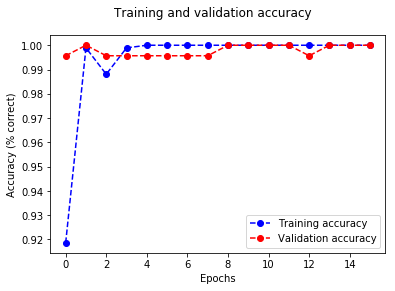

In [26]:
fig = bn.plot_accuracy(training)

In [81]:
sub2_t1_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape_subj2=sub2_t1_img.shape[0:3]
vol_shape_subj2

(182, 218, 182)

In [89]:
streamlines_all_s1 = bn.read_sl_mni('/home/ubuntu/recobundles/100307/out_work/whole_brain_MNI_tracks_from_sh__moved.trk') 

In [97]:
imp.reload(bn)
map_files = sorted(glob('/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
labeled_index_s1, labels_s1 = bn.getlabeledstreamlines(map_files)
unlabeled_index_s1 = bn.getunlabeledstreamlines(len(streamlines_all_s1), labeled_index_s1, len(streamlines_all_s1)-len(labeled_index_s1), 0)
labels_selected_s1, streamlines_selected_s1 = bn.combinestreamlines(labeled_index_s1, unlabeled_index_s1, labels_s1, streamlines_all_s1)

In [93]:
np.max(unlabeled_index_s1)

207617

In [33]:
#move to bundlenet - getstreamlinesreco
map_files = sorted(glob('/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
map_file_index = []
labels_subj1 = []
for m_idx, m in enumerate(map_files):
    tmp = np.load(m)
    map_file_index = np.append(map_file_index,tmp)
    labels_subj1 = np.append(labels_subj1,m_idx*np.ones([len(tmp),1]))

In [34]:
ind = range(len(streamlines_all1))
ind = np.delete(ind,map_file_index)
#np.random.shuffle(ind)
num_unlabeled = ind.shape[0] #len(map_file_index)
unlabeled_streamlines = ind[0:num_unlabeled]
labels_subj1 = np.append(labels_subj1,16*np.ones([num_unlabeled,1]))

In [35]:
np.append(map_file_index,unlabeled_streamlines)

array([186748., 199724., 199806., ..., 207661., 207662., 207663.])

In [36]:
streamlines_all_subj1 = [streamlines_all1[i] for i in np.int_(np.append(map_file_index,unlabeled_streamlines))]
len(streamlines_all_subj1)
len(labels_subj1)

207706

In [37]:
len(streamlines_all1)

207664

array([ 0.,  0.,  0., ..., 15., 15., 15.])

In [44]:
if op.exists('./streamlines_processed_100307.npy'):
    streamlines_all_processed_subj1 = np.load('streamlines_processed_100307.npy')
else:
    %%time 
    imp.reload(bn)
    streamlines_all_processed_subj1 = bn.process_sl(streamlines_all_subj1,-1,vol_shape_subj2,size_slimage,dil_iters)
    np.save('streamlines_processed_100307.npy',streamlines_all_processed_subj1)

In [45]:
p_subj1 = model.predict(streamlines_all_processed_subj1, batch_size=5)

In [46]:
p_idx = np.argmax(p_subj1, axis=-1)
max(labels_subj1)

16.0

In [47]:
bn.print_accuarcystats(p_idx[labels_subj1<16],labels_subj1[labels_subj1<16])

Percent correct is 0.9878716063151292 
Kappa is: 0.9853202289760269
Jaccard is: 0.9878716063151292


In [51]:
#move to bundlenet - leanwithxgboost
import xgboost as xgb
from sklearn.cross_validation import train_test_split
param = {
    'max_depth': 10,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 17}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations
X_train, X_test, y_train, y_test = train_test_split(p_subj1, labels_subj1, test_size=0.2, random_state=42, stratify=labels_subj1)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)
p = np.argmax(preds,axis=1)

In [52]:
p_idx[labels_subj1==16]

array([1, 1, 1, ..., 0, 3, 3])

(array([1.7000e+01, 3.0000e+00, 1.1000e+02, 4.6000e+01, 5.2000e+01,
        1.8000e+01, 7.0000e+00, 1.6000e+01, 5.0000e+00, 1.0000e+00,
        1.0000e+00, 9.0000e+00, 1.8000e+01, 1.7000e+01, 4.0000e+00,
        1.0000e+00, 3.5478e+04]),
 array([ 0.        ,  0.94117647,  1.88235294,  2.82352941,  3.76470588,
         4.70588235,  5.64705882,  6.58823529,  7.52941176,  8.47058824,
         9.41176471, 10.35294118, 11.29411765, 12.23529412, 13.17647059,
        14.11764706, 15.05882353, 16.        ]),
 <a list of 17 Patch objects>)

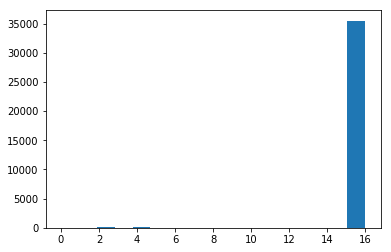

In [63]:
ind=y_test==16
plt.hist(p[ind],bins=17)

In [54]:
perc_correct = np.zeros((17,1))
nsl = np.zeros((17,1))
for i in range(17):
    ind = y_test == i
    nsl[i] = np.sum(ind)
    perc_correct[i] = np.sum(p[ind]==i)/np.sum(ind)
    

In [55]:
perc_correct

array([[0.9704918 ],
       [0.92682927],
       [0.96527428],
       [0.96613546],
       [0.96262741],
       [0.96435644],
       [0.98268398],
       [0.8359375 ],
       [0.87596899],
       [0.93333333],
       [0.81481481],
       [0.95      ],
       [0.94007491],
       [0.58857143],
       [1.        ],
       [0.72222222],
       [0.99092255]])

In [64]:
nsl

array([[3.0500e+02],
       [8.2000e+01],
       [1.9870e+03],
       [5.0200e+02],
       [8.8300e+02],
       [5.0500e+02],
       [4.6200e+02],
       [1.2800e+02],
       [1.2900e+02],
       [1.5000e+01],
       [2.7000e+01],
       [2.2000e+02],
       [2.6700e+02],
       [1.7500e+02],
       [3.4000e+01],
       [1.8000e+01],
       [3.5803e+04]])

In [65]:
streamlines_all2 = bn.read_sl_mni('/home/ubuntu/recobundles/100408/out_work/whole_brain_MNI_tracks_from_sh__moved.trk')
map_files = sorted(glob('/home/ubuntu/recobundles/100408/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
map_file_index = []
labels_subj2 = []
for m_idx, m in enumerate(map_files):
    tmp = np.load(m)
    map_file_index = np.append(map_file_index,tmp)
    labels_subj2 = np.append(labels_subj2,m_idx*np.ones([len(tmp),1]))

ind = range(len(streamlines_all2))
ind = np.delete(ind,map_file_index)
num_unlabeled = ind.shape[0] #len(map_file_index)
#np.random.shuffle(ind)
unlabeled_streamlines = ind[0:num_unlabeled]
labels_subj2 = np.append(labels_subj2,16*np.ones([num_unlabeled,1]))
np.append(map_file_index,unlabeled_streamlines)

streamlines_all_subj2 = [streamlines_all2[i] for i in np.int_(np.append(map_file_index,unlabeled_streamlines))]

streamlines_all_processed_subj2 = bn.process_sl(streamlines_all_subj2,-1,vol_shape_subj2,size_slimage,dil_iters)
p_subj2 = model.predict(streamlines_all_processed_subj2, batch_size=5)
np.save('streamlines_processed_100408.npy',streamlines_all_processed_subj1)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [66]:
np.save('streamlines_processed_100408.npy',streamlines_all_processed_subj2)

In [67]:
import xgboost as xgb
from sklearn.cross_validation import train_test_split
param = {
    'max_depth': 10,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 17}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations
#X_train, X_test, y_train, y_test = train_test_split(p_subj1, labels_subj1, test_size=0.2, random_state=42, stratify=labels_subj1)
dtrain = xgb.DMatrix(p_subj1, label=labels_subj1)
dtest = xgb.DMatrix(p_subj2, label=labels_subj2)
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)
preds_max = np.argmax(preds,axis=1)

In [68]:
len(y_test)

41542

array([[0.49266862],
       [0.74447031],
       [0.81166782],
       [0.59446494],
       [0.36433631],
       [0.16482412],
       [0.81646274],
       [0.42119276],
       [0.45290581],
       [0.14634146],
       [0.44404332],
       [0.82339317],
       [0.35379203],
       [0.18032787],
       [0.4673913 ],
       [0.20996441],
       [0.9756055 ]])

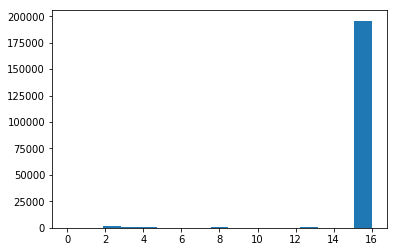

In [71]:
ind=labels_subj2==16
plt.hist(preds_max[ind],bins=17)
perc_correct = np.zeros((17,1))
nsl = np.zeros((17,1))
for i in range(17):
    ind = labels_subj2 == i
    nsl[i] = np.sum(ind)
    perc_correct[i] = np.sum(preds_max[ind]==i)/np.sum(ind)
perc_correct

array([[1.        ],
       [1.        ],
       [0.9546679 ],
       [1.        ],
       [0.89066831],
       [0.97889447],
       [1.        ],
       [0.94621938],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.90793283],
       [0.98358092],
       [0.99943471],
       [1.        ],
       [1.        ],
       [0.        ]])

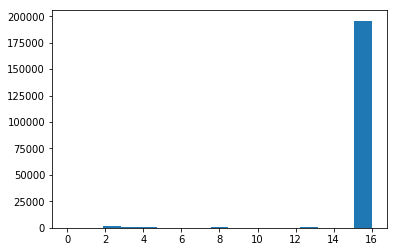

In [72]:
#??
p_2 = np.argmax(p_subj2,axis=1)
ind=labels_subj2==16
plt.hist(preds_max[ind],bins=17)
perc_correct = np.zeros((17,1))
nsl = np.zeros((17,1))
for i in range(17):
    ind = labels_subj2 == i
    nsl[i] = np.sum(ind)
    perc_correct[i] = np.sum(p_2[ind]==i)/np.sum(ind)
perc_correct

In [73]:
p_subj2_withclass = model.predict(streamlines_all_processed_subj2[preds_max<16,:,:,:], batch_size=5)

In [74]:
l = labels_subj2[preds_max<16]
p_withclass_2 = np.argmax(p_subj2_withclass,axis=1)
perc_correct = np.zeros((16,1))
nsl = np.zeros((16,1))
for i in range(16):
    ind = l == i
    nsl[i] = np.sum(ind)
    perc_correct[i] = np.sum(p_withclass_2[ind]==i)/np.sum(ind)
perc_correct

array([[1.        ],
       [1.        ],
       [0.99981037],
       [1.        ],
       [0.87768718],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.97327707],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ]])

In [55]:
imp.reload(bn)
streamlines_all2_nomni = bn.read_sl('/home/ubuntu/recobundles/100408/out_work/whole_brain_MNI_tracks_from_sh__moved.trk')
streamlines_all_nomni_subj2 = [streamlines_all2_nomni[i] for i in np.int_(np.append(map_file_index,unlabeled_streamlines))]

In [56]:
tmp = np.where(p<16)
t = tmp[0]
classified_streamlines = [streamlines_all_nomni_subj2[i] for i in t ]

In [57]:
probs = np.max(p_subj2_nounclass,axis=1)

NameError: name 'p_subj2_nounclass' is not defined

In [ ]:
bundle_names

In [ ]:
imp.reload(bn)
for i, bund in enumerate(bundle_names):
    bn.savesegtrk(classified_streamlines, p_withclass_2, i, probs, 0.9,'TRK/'+bund+'.trk',0)